In [17]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pnorm
from optic.metrics import signal_power
from optic.plot import pconst
from numba import njit

In [18]:
# plt.figsize(3,3)

In [132]:
# @njit
# import numpy as np

def mlse(y, r, symb, L):
    
    S = symb.flatten()
    r = r.flatten()

    d = DM(y, r)    
    dec = np.zeros(y.shape)
    
    for k in range(L, len(y)):
        indMin = np.argmin(np.sum(d[:,k-L:k],axis=1))
        dec[k] = S[indMin]
        
    return dec
    

def dec2bit(dec, bitL):
    bits = bin(dec)[2:]  # Convert decimal to binary string
    bits = bits.zfill(bitL)  # Pad with leading zeros
    return [int(bit) for bit in bits]

def DM(y, r):
    r = r.flatten()
    dist = np.zeros((len(r), len(y)))
    
    for k, v in enumerate(y):
        dist[:,k] = np.abs(v-r)**2
        
    return dist

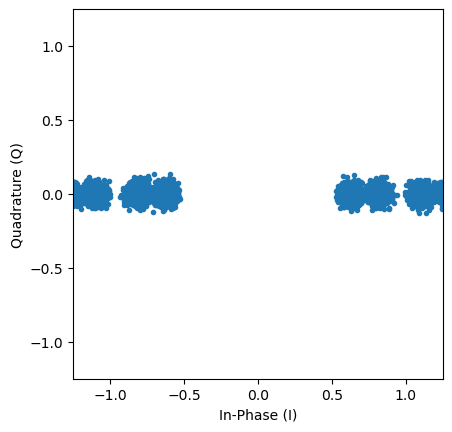

In [161]:
M = 2

h = np.array([1, 0.25, 0.1])
constSymb = GrayMapping(M, 'pam')   # Gray constellation mapping

# parâmetros da simulação
SpS = 1   # Amostras por símbolo

# get constellation    
constSymb = GrayMapping(M, 'pam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(10000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# adição de ISI
sigTx = np.convolve(h, symbTx, mode='valid')
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0025 # variância
μ   = 0      # média

σ      = np.sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))

sigRx = sigTx + ruido

pconst(sigRx, pType='fast');

In [162]:
L = len(h)
bits = np.zeros((M**L, L), dtype=int)

for k, dec in enumerate(range(M**L)):    
    bits[k,:] = dec2bit(dec, L)

symb = 2*bits-1

r = np.sum(symb*h, axis=1)

sig = pd.DataFrame(data=symb, index=np.arange(M**L))
pd.options.display.float_format = '{:,.2f}'.format

sig = pd.DataFrame(data=bits, index=[i for i in range(symb.shape[0])], columns=[f'b{-i}' for i in range(symb.shape[1])])
sig['r'] = r
sig

,b0,b-1,b-2,r
0,0,0,0,-1.35
1,0,0,1,-1.15
2,0,1,0,-0.85
3,0,1,1,-0.65
4,1,0,0,0.65
5,1,0,1,0.85
6,1,1,0,1.15
7,1,1,1,1.35


In [169]:
dec = mlse(sigRx, r, bits[:,0], len(h))

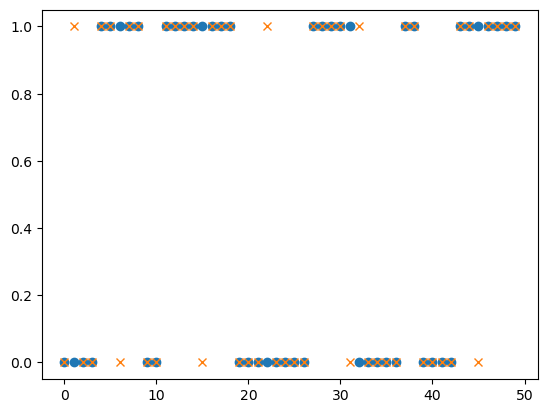

In [170]:
plt.plot(dec[0:50],'o')
plt.plot(bitsTx[0:50],'x');

In [171]:
BER = np.logical_xor(sigRx>=0, bitsTx[2:]).sum()/len(bitsTx)
print(f'BER = {BER:.2e}')

BER = np.logical_xor(dec, bitsTx[2:]).sum()/len(bitsTx)
print(f'BER = {BER:.2e}')

BER = 0.00e+00
BER = 4.91e-01
